In [45]:
import pandas as pd

df = pd.read_csv('train-data.dat', sep=',', header=None)  #Reads train data
df.columns = ['sentence']
df['sentence'] = df['sentence'].str.replace('<.*?>', '', regex=True)  #Deletes <int>
df = df[0:1000]
df.head()

vocab = pd.read_csv('vocabs.txt', sep=',', header=None)   #Reads vocabulary
vocab.columns = ['word', 'id']

# sentences = pd.read_csv('train-data.dat', sep=',', header=None)
# sentences.head()

com = []
for line in df.sentence:      #Creates sentences based on train data and vocabulary
    sen = ''
    for word in line.split():
      for id in vocab.id:
        if int(word) == int(id):
          sen = sen + ' ' + str(vocab.word[id]) 
    # print(sen)
    com.append(sen)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectors = tfidf_vectorizer.fit_transform(com)

tfidf = tfidf_vectors.todense() 
tfidf[tfidf == 0] = np.nan  #Replaces 0 with nan values

means = np.nanmean(tfidf, axis=0) #Calculates mean, ignoring nan values
means = dict(zip(tfidf_vectorizer.get_feature_names(), means.tolist()[0]))  #Converts it into a dictionary for later lookup

tfidf = tfidf_vectors.todense()
ordered = np.argsort(tfidf*-1)  #Sorts the full TFIDF dense vector
words = tfidf_vectorizer.get_feature_names()  #Creates vectors

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
li = [[]]

for key in means:
  li.append([key, means[key]])

li.pop(0)
li[:5]

df2 = pd.DataFrame(li)  #Creates values for evaluation function
df2.head()

tfidf_sc = df2[1]
# print(tfidf_sc)

tfidf_len = len(tfidf_sc) #Length of each individual
# print(tfidf_len)  

In [57]:
import importlib.util

package_name = 'deap'

spec = importlib.util.find_spec(package_name)
if spec is None:
  !pip install deap #Installs Deap library to make the genetic algorithm
else:
  pass

import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

POP_SIZE = 20 #Population Size
MAX_GENERATIONS = 50
GENERATIONS_EXIT = 10  #State the number of generations in which maxFitness remains the same,  for stopping condition


creator.create("FitnessMax", base.Fitness, weights=(1.0,))  #Fitness of GA
creator.create("Individual", list, fitness=creator.FitnessMax) #Sets fitness for individuals

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [58]:
df2.columns=['word', 'importance']  #Names df2 columns

def evaluation_function(individual):  #Evaluation function based on TF_IDF score

  sum = 0
  a = 0
  for i in individual:
    if i==1:
      a += df2.importance[i]
      sum += 1
  # a = a/sum

  counter = 0 
  for i in individual:  #Sets penalty for >1000 values of 1
    if i==1:
      counter+=1
  if counter<1000:
    a -= 50
  else:
    pass
  
  return a, 

In [59]:
tbx = base.Toolbox()

INDIVIDUAL_SIZE = tfidf_len #Sets individual length

tbx.register("attr_bool", random.randint, 0, 1) #Function for individual creation
tbx.register('individual', tools.initRepeat, creator.Individual, tbx.attr_bool, INDIVIDUAL_SIZE)  #Creates individual 
tbx.register("population", tools.initRepeat, list, tbx.individual)  #Creates population

tbx.register("evaluate", evaluation_function) #Sets Evaluation function
tbx.register("select", tools.selTournament, tournsize=3)  #Sets select 
tbx.register("mate", tools.cxUniform, indpb=0.5)  #Sets mating method
tbx.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.8) #Sets mutation method

In [60]:
def main():

  maxFitValues = []
  maxGenValues = []
  best_indx = []
  best = {}

  for i in range(10): #10 iteration due to the stochastic nature of genetic algorithm
    print('Iteration {} --->'.format(i))
    pop = tbx.population(POP_SIZE)

    fitnesses = list(map(tbx.evaluate, pop))  #Puts fitnesses in tuple with each individual

    maxFitnessValues = []
    meanFitnessValues = []
    genbest = {}

    for ind, fit in zip(pop, fitnesses):  #Sets fitness value for each individual
      ind.fitness.values = fit

    CXPB, MUTPB = 0.6, 0.1  #Mating and Mutation probabilities

    fits = [ind.fitness.values[0] for ind in pop]

    g = 0 #Keeps track of the number of generations

    while g < MAX_GENERATIONS: #Begins the evolution
      if g > GENERATIONS_EXIT and ( #Stopping Conditions as requested
                    all(v == maxFitnessValues[len(maxFitnessValues) - 1] for v in maxFitnessValues[
                                                                                  (len(maxFitnessValues) - GENERATIONS_EXIT):len(maxFitnessValues)])):
        print("Stopping Conditions Occured.")
        break
      
      g = g + 1
      # print("-- Generation %i --" % g)

      offspring = tbx.select(pop, len(pop)) #Selects next generation individuals
      
      offspring = list(map(tbx.clone, offspring)) #Clones selected individuals

      
      for child1, child2 in zip(offspring[::2], offspring[1::2]): #Applies mating and mutation on the offspring
        if random.random() < CXPB:
          tbx.mate(child1, child2)
          del child1.fitness.values
          del child2.fitness.values

      for mutant in offspring:
        if mutant != tools.selBest(offspring, 3, fit_attr="fitness"): #Elitism - Elitist individuals do not get mutated
          if random.random() < MUTPB:
            tbx.mutate(mutant)
            del mutant.fitness.values

      invalid_ind = [ind for ind in offspring if not ind.fitness.valid] #Evaluates the individuals with an invalid fitness
      fitnesses = map(tbx.evaluate, invalid_ind) 
      for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
 
      pop[:] = offspring  #Replaces the old population with the offspring

      fitnessValues = [ind.fitness.values[0] for ind in pop]  #Puts fitnesses together
      
      maxFitness = int(max(fitnessValues))
      meanFitness = int(sum(fitnessValues) / len(pop))
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      print("- Generation {}: Max Fitness = {}, Avg Fitness = {}"
                  .format(g, maxFitness, meanFitness))
      
      best_index = fitnessValues.index(max(fitnessValues))  #Sets index of best fitness

      # print(maxFitness, pop[best_index])
      genbest[maxFitness] = pop[best_index] #Creates tuple with best individual and its fitness

    maxGenValues.append(g)  #Appends generation number
    maxFitValues.append(max(maxFitnessValues))  #Appends maximum Fitness values of each generation
    
    best.update(genbest)  #Updates tuple of best individuals and their fitnesses
   

  best = sorted(best.items()) #Sorts tuple of best individuals and their fitnesses
  alpha = list(best)[-1]  #Grabs the best individual out of every generation and iteration
  # print('Alpha Individual: ', alpha[1])


  print("Average Fitness of best individual is:", np.mean(maxFitValues))
  print("Best Fitness of best individual is:", np.amax(max(maxFitValues)))
  print("Average generation when stopping conditions are met:", np.mean(maxGenValues))
  plt.figure(0)
  plt.plot(maxFitnessValues, color='red')
  plt.plot(meanFitnessValues, color='green')
  plt.xlabel('Generation')
  plt.ylabel('Max / Average Fitness')
  plt.title('Max and Average fitness over Generations')
  plt.show()

  # brain(alpha)
  return alpha

In [52]:
X = []                                #Creates bag of words array 
for y in df.sentence:
  x_counter = [0] * 8519
  for w in y.split():
    for i in range(8520):
      if int(w) == i:
        x_counter[i] = x_counter[i] + 1
  X.append(x_counter)
X = pd.DataFrame(X) 
# X

In [53]:
zero_indices = []
counter = 0
for i in alpha[1]:  #Creates list with index of zeros in best individual
  if i==0:
    zero_indices.append(counter)
  counter +=1

# print(zero_indices)

X_short = pd.DataFrame()

for j in zero_indices:  #Creates input dataframe based on the most important words based on the best individual
  X_short[j] = X[j]

# X_short.shape
input_len = len(X_short.columns)  #Input length for neural network
# input_len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


1316

In [54]:
y = pd.read_csv('train-label.dat', sep=',', header=None)       #Reads output data
y.columns = ['label']       #Sames output data column
y = y[0:1000]
y = y['label'].str.split(' ', expand=True)          #Splits data into 20 columns
y = y.astype(int)       #Makes output data integers
# y

In [55]:
import tensorflow as tf

X_short = tf.keras.utils.normalize(X_short, axis=1)   #Normalizes input data

Iteration 0 --->
- Generation 1: Max Fitness = 374, Avg Fitness = 364
- Generation 2: Max Fitness = 378, Avg Fitness = 368
- Generation 3: Max Fitness = 378, Avg Fitness = 371
- Generation 4: Max Fitness = 381, Avg Fitness = 374
- Generation 5: Max Fitness = 381, Avg Fitness = 378
- Generation 6: Max Fitness = 382, Avg Fitness = 379
- Generation 7: Max Fitness = 382, Avg Fitness = 379
- Generation 8: Max Fitness = 385, Avg Fitness = 381
- Generation 9: Max Fitness = 385, Avg Fitness = 379
- Generation 10: Max Fitness = 386, Avg Fitness = 381
- Generation 11: Max Fitness = 387, Avg Fitness = 383
- Generation 12: Max Fitness = 386, Avg Fitness = 383
- Generation 13: Max Fitness = 386, Avg Fitness = 386
- Generation 14: Max Fitness = 386, Avg Fitness = 383
- Generation 15: Max Fitness = 388, Avg Fitness = 385
- Generation 16: Max Fitness = 388, Avg Fitness = 383
- Generation 17: Max Fitness = 389, Avg Fitness = 385
- Generation 18: Max Fitness = 389, Avg Fitness = 386
- Generation 19: Max

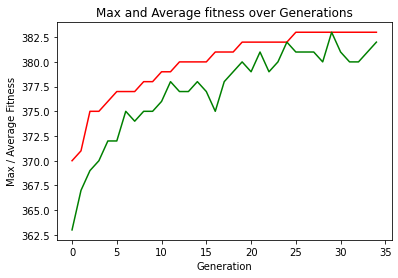

In [61]:
alpha = main()  #Run the Genetic Algorithm, creates variable of the best individual 

Select number of hidden layer neurons:
	 1. equal to output neurons
	 2. equal to (output neurons + input neurons) / 2
	 3. equal to output neurons + input neurons
2

Epoch 1: binary_accuracy improved from -inf to 0.49186, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.49186 to 0.50500, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.50500 to 0.51779, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.51779 to 0.53114, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.53114 to 0.54714, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.54714 to 0.56007, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.56007 to 0.57350, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.57350 to 0.58629, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.58629 to 0.59821, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.59821 to 0.61157, sa

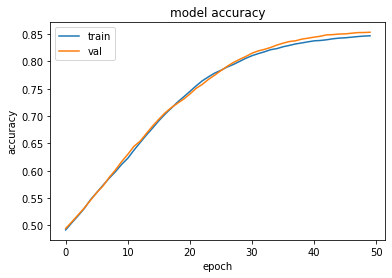


Epoch 1: binary_accuracy improved from -inf to 0.45550, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.45550 to 0.47036, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.47036 to 0.48293, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.48293 to 0.49686, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.49686 to 0.51386, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.51386 to 0.52786, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.52786 to 0.54243, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.54243 to 0.55657, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.55657 to 0.57079, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.57079 to 0.58486, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.58486 to 0.59650, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.59650 to 0.6

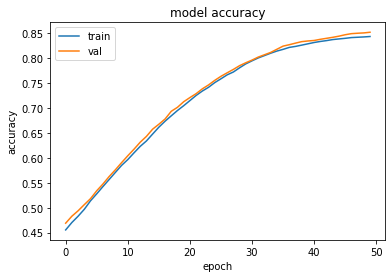


Epoch 1: binary_accuracy improved from -inf to 0.55457, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.55457 to 0.56721, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.56721 to 0.58300, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.58300 to 0.59743, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.59743 to 0.61064, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.61064 to 0.62236, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.62236 to 0.63471, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.63471 to 0.64664, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.64664 to 0.65857, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.65857 to 0.67150, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.67150 to 0.68300, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.68300 to 0.6

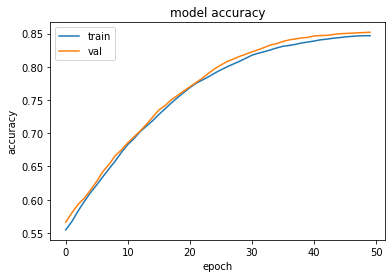


Epoch 1: binary_accuracy improved from -inf to 0.54057, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.54057 to 0.55486, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.55486 to 0.56979, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.56979 to 0.58450, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.58450 to 0.59771, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.59771 to 0.61093, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.61093 to 0.62421, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.62421 to 0.63536, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.63536 to 0.64907, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.64907 to 0.66257, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.66257 to 0.67471, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.67471 to 0.6

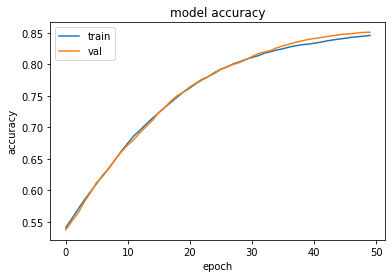


Epoch 1: binary_accuracy improved from -inf to 0.57493, saving model to best_m.h5

Epoch 2: binary_accuracy improved from 0.57493 to 0.58914, saving model to best_m.h5

Epoch 3: binary_accuracy improved from 0.58914 to 0.60400, saving model to best_m.h5

Epoch 4: binary_accuracy improved from 0.60400 to 0.61736, saving model to best_m.h5

Epoch 5: binary_accuracy improved from 0.61736 to 0.63207, saving model to best_m.h5

Epoch 6: binary_accuracy improved from 0.63207 to 0.64586, saving model to best_m.h5

Epoch 7: binary_accuracy improved from 0.64586 to 0.65893, saving model to best_m.h5

Epoch 8: binary_accuracy improved from 0.65893 to 0.67114, saving model to best_m.h5

Epoch 9: binary_accuracy improved from 0.67114 to 0.68214, saving model to best_m.h5

Epoch 10: binary_accuracy improved from 0.68214 to 0.69471, saving model to best_m.h5

Epoch 11: binary_accuracy improved from 0.69471 to 0.70743, saving model to best_m.h5

Epoch 12: binary_accuracy improved from 0.70743 to 0.7

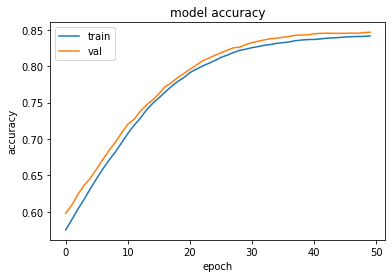

In [62]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D
from keras import regularizers
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from tensorflow import keras
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt


kfold = KFold(n_splits=5, shuffle=True)
rmseList = []

X_train, X_test, y_train, y_test = train_test_split(X_short, y, test_size=0.3, random_state=42)       #Splits data into train, test

hl_n = 0
answer = input('Select number of hidden layer neurons:\n\t 1. equal to output neurons\n\t '
  '2. equal to (output neurons + input neurons) / 2\n\t 3. equal to output neurons + input neurons\n')
if answer == '1':
  hl_n = 20                   #Hidden layer neurons number
elif answer == '2':
  hl_n = int((20 + input_len) / 2)
elif answer == '3':
  hl_n = input_len

# opt = keras.optimizers.Adam(learning_rate=0.01)                   #Adam
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)       #Sgd

for i, (train, test) in enumerate(kfold.split(X)):
  model = Sequential()
  # model.add(Dense(input_len, input_shape=(input_len,), activation='softmax', kernel_regularizer=regularizers.l2(0.1)))      #Kernel l2 regulirization
  model.add(Dense(input_len, input_shape=(input_len,), activation='relu'))          #Input
  model.add(Dense(hl_n, activation='relu'))                       #Hidden
  # model.add(Dense(hl_n2, activation='relu'))                         #2nd hidden
  model.add(Dense(20, activation='sigmoid'))                      #Output

  model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  # loss='mean_squared_error',
  # metrics=[rmse]
  metrics=['binary_accuracy']
  )

  es = EarlyStopping(             #Early stopping
      monitor='val_loss',
      patience=5,
      verbose=0,
      mode='min'
  )

  mc = ModelCheckpoint(       #Model checkpoint to save best model each epoch
      'best_m.h5',
      monitor='binary_accuracy',
      mode='max',
      verbose=1,
      save_best_only=True
  )

  history = model.fit(X_train, y_train,           #Model fit
            validation_data=(X_test, y_test),
            epochs=50,
            callbacks=[es, mc],
            verbose=0)

  print('val_loss, val_acc: ', model.evaluate(X_test, y_test), sep='')        #Model evaluation

  scores = model.evaluate(X_test, y_test, verbose=0)
  rmseList.append(scores[0])
  print("Fold :", i+1, " loss", scores[0])

  plt.plot(history.history['binary_accuracy'])            #Plots accuracy, val_accuracy/epoch graph
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()